# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
        
        
        
        
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [3]:
# Define global functions here, if required
def calculate_regret_bound(rho, t, play_count):
    '''calculation of the uncertainty term in UCB MAB'''
    bound = 0
    if play_count > 0:
        bound = np.sqrt(rho * np.log(t) / play_count)
    return bound



def find_match(mab,arms, contexts, n_step):
    '''recursively step through stored events S to identify the case where an arm played by MAB matches a given logged event
    returns 1 when there is a match and which round it happened'''
    
    
    if n_step < len(arms): #Len(arms) represent number of rows of dataset, n_step tracks which row are we at in the dataset
        next_arm = arms[n_step] #historical log 
        chosen_arm = mab.play(contexts[n_step][:][:]) 
        if chosen_arm == next_arm:
            return [True,n_step]
        
    # return False if no match found before it reaches the end of line
    if n_step >= len(arms):
        return [False, -1]
    
    
    else:

        return find_match(mab,arms, contexts, n_step+1)

    
    
def best_gamma_eta_combo(results,gamma_values,eta_values):
    
    max_coord = np.where(results == np.max(results))
    g = list(gamma_values[list(max_coord[1])])
    e = list(eta_values[list(max_coord[0])])
    out_pair = list(zip(g,e))

    
    return out_pair

## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        
        if not np.issubdtype(type(epsilon), np.float):
            raise TypeError("`epsilon` must be a decimal number")
        if not (epsilon >= 0 and epsilon<=1):
            raise ValueError("`epsilon` must be in the interval [0,1]")
            
        self.n_arms = n_arms
        self.n_arms = n_arms
        self.epsilon = epsilon
        
        #track the amount of times each arm has been pulled
        self.n_played = np.zeros(n_arms,dtype=int)
        
        
        #track the average reward of each arm, with starting value as Q0 = inf
        self.Q_val = np.full(n_arms,Q0,dtype=float)
        
        
    def play(self, context=None):
        super().play(context)
        # your code here
        chosen_arm = 0 
        explore = np.random.rand() < self.epsilon
        #since all Qvalues starts at inf, we play all arms once to zerorise the values before resorting to playing by mean rewards
        #this has been empirically tested and the results show improved rewards
        if len(np.where(self.Q_val == np.inf)[0]) > 0:
            #randomly play an arm and set it to zero to avoid replaying it (tested and proven to improve average rewards)
            chosen_arm = np.random.choice(np.where(self.Q_val==max(self.Q_val))[0])
            self.Q_val[chosen_arm] = 0
        elif explore:
            #explore: randomly choose an arm
            chosen_arm = np.random.choice(self.n_arms) #note to self: index directly represents the arm number
        else:
            #exploit: choose the arm with the highest Q-value (if there are multiple maximum Q-values, randomly choose any 1)
            chosen_arm = np.random.choice(np.where(self.Q_val==max(self.Q_val))[0])

        return chosen_arm
    
    
    
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        
        #increase the play counter for selected arm by 1
        self.n_played[arm] += 1
        
        #update the Q-value of the selected arm
        self.Q_val[arm] =  ((self.n_played[arm] - 1) * self.Q_val[arm] + reward) / self.n_played[arm]


In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        self.n_arms = n_arms
        self.rho = rho
        self.Q0 = Q0
        
        #track the amount of times each arm has been pulled
        self.n_played = np.zeros(self.n_arms)
        
        
        #track the average reward of each arm, with starting value as Q0 = inf
        self.reward_mean = np.full(self.n_arms,self.Q0,dtype=float)
        
        #track the total rounds played so far, starting with round one
        self.t = 1
        
        
    def play(self, context=None):
        super().play(context)
        # your code here
        Q_val = np.zeros(self.n_arms,dtype=float)
        
        #since all Qvalues starts at inf, we play all arms once to zerorise the values before resorting to playing by mean rewards
        #this has been empirically tested and the results show improved rewards
        if len(np.where(self.reward_mean == np.inf)[0]) > 0:
            #randomly play an arm and set it to zero to avoid replaying it
            chosen_arm = np.random.choice(np.where(self.reward_mean==max(self.reward_mean))[0])
            self.reward_mean[chosen_arm] = 0
            
        #compute the Q-value of each arm (normal rules)
        #After each round the Q-value will be updated for each arm based on t regardless of the selection
        else:
            for i in range(self.n_arms):
                Q_val[i] = self.reward_mean[i] + calculate_regret_bound(self.rho, self.t, self.n_played[i])
            
        #choose the arm with the highest uncertainty-adjusted Q-value 
        chosen_arm = np.random.choice(np.where(Q_val==max(Q_val))[0])
        return chosen_arm
        

        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        
        #update the number of plays for the chosen arm
        self.n_played[arm] += 1
        
        #update the next round
        self.t += 1
        
        #SPECIAL CASE: if it is the first update, we keep the internal state unchanged 
        if self.n_played[arm] > 1:
            # Update average/mean value/reward for chosen arm
            self.reward_mean[arm] =  ((self.n_played[arm] - 1) * self.reward_mean[arm] + reward) / self.n_played[arm]
        else:
            self.reward_mean[arm] = reward

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms} #should be 0...mab.n_arms-1 (tested)
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history
        the 1-st axis indexes the arms
        2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # Start with empty history and zero total payoff
    R = np.zeros(n_rounds, dtype=float)
    hist = []
    chosen_arm = 0
    n_step = 0
    big_T = 0
    if n_rounds == None:
        n_rounds = len(arms)+1 #if None, make sure it evaluates till the end of the log
    #step through the stream of logged events S
    for t in range(n_rounds):

        #look for the case where the recommendation policy agrees with each other (aka. same arm is chosen)
        found, match_step = find_match(mab, arms, contexts, n_step)
        if found:
            context = contexts[match_step]#[:][:]
            chosen_arm = arms[match_step] 
            reward = rewards[match_step]

            #concatenate the history information
            hist.append((context, chosen_arm, reward))

            #update the reward information given arm of choice and context 
            mab.update(chosen_arm, reward, context)

            #update the total payoff
            R[t] += reward

            #increment number of matched events by 1
            big_T += 1

            #save our next position in the dataset to avoid double computation
            n_step = match_step + 1

        else: #fail-safe, if we have reached the end of the dataset before satisfying n_rounds
            print("you have reached the end of the log. No further matches found.")
            break
    
    return R

In [7]:
# load dataset here
#Read the file and extract arms, rewards, and contexts
data = np.loadtxt("dataset.txt", dtype = int)
arms, rewards, contexts = data[:, 0], data[:, 1], data[:, 2:]

In [8]:
for i in range(5):
    print(arms[i])
#Note: Manual inspection suggests that the value of arms is encoded using indices in the range 1-10
#However upon reading this into our notebook, it became 0-9, so it uses the same encoding as the classes

1
7
4
3
1


In [9]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.13875


In [10]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.28125


## 3. Implement LinUCB contextual MAB

In [11]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        if not np.issubdtype(type(n_dims), np.integer):
            raise TypeError("`n_dims` must be an integer")
        if not n_dims >= 0:
            raise ValueError("`n_dims` must be non-negative")
        if not alpha >= 0:
            raise ValueError("`alpha` must be more than zero")
            
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.alpha = alpha #alpha represents the explore-exploit parameter
        
        #initialise A as a n_arms * n_dims * n_dims matrix, where each arm corresponds to a ndims-dimensional identity matrix
        self.A = np.zeros((n_arms, n_dims, n_dims))
        for arm in range(n_arms):
            self.A[arm] = np.eye(self.n_dims)
        #b is a narms * ndims matrix, where each arm corresponds to a ndims-dimensional zero vector
        self.b = np.zeros((n_arms, n_dims))
        
        
    def play(self, context):
        super().play(context)
        # your code here
        
        #initialise estimated mean theta matrix, size: n_arms * n_dims 
        theta = np.array([np.linalg.inv(self.A[a]) @ self.b[a] for a in range(self.n_arms)])
        
        #initialise the p term, each arm corresponds to one payoff term
        p = np.zeros(self.n_arms)
        
        #reshape context for matrix multiplication with theta
        cntxt = context.reshape(self.n_arms, self.n_dims)

        for a in range(self.n_arms):
            #update the p term for each arm
            p[a] = theta[a].T @ cntxt[a] + self.alpha * np.sqrt(cntxt[a].T @ np.linalg.inv(self.A[a]) @ cntxt[a])
            
        #choose arm with highest payoff value, choose uniformly at random if maximum value is not unique
        chosen_arm = np.random.choice(np.where(p == max(p))[0])
        return chosen_arm
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        #reshape context for matrix addition
        cntxt = context.reshape(self.n_arms, self.n_dims)

        #accessing based on index gives an array form (,n_dims), so we need to transform it into a 1D vector
        cntxt_arm_v = np.array([cntxt[arm]]) #shape is now (1,n_dims)
        self.A[arm] += cntxt_arm_v.T @ cntxt_arm_v #resulting shape is (n_dims, n_dims) per arm
        self.b[arm] += reward * cntxt[arm]

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [13]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        
        if not np.issubdtype(type(n_dims), np.integer):
            raise TypeError("`n_dims` must be an integer")
        if not n_dims >= 0:
            raise ValueError("`n_dims` must be non-negative")
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.tree = tree
        
        #track the number of times each arm has been pulled
        self.n_played = np.zeros(self.n_arms, dtype = int)
        
        #initialise D for storing historical log of context-reward pair for each arm later
        self.D = list('0' for a in range(self.n_arms))


    def play(self, context):
        super().play(context) #context here is a collection of context vectors (one for each arm)
        # your code here
        # NOTE : t is looped outside
        
        
        #track the estimated success from applying tree theta to context for each arm
        p_hat = np.zeros(self.n_arms, dtype = float)
        res = np.zeros(self.n_arms) #actual predictions
        D = self.D
        
        #reshape the context to have size (n_arms, n_dims)
        cntxt = context.reshape(self.n_arms, self.n_dims)
    
        for a in range(self.n_arms):
            
            if not isinstance(D[a], (list, tuple, np.ndarray)): #if there is no historical data for an arm available return 1
                res[a] = 1.0
                p_hat[a] = 1.0

            else:

                #bootstrap sample dataset D
                sample_size = D[a].shape[0]
                num_samples = 1
                idx = np.random.randint(0,sample_size, size=(num_samples,sample_size))
                bootstrapped_D = D[a][idx[0]]
                
                #split into X(context) and Y(reward)
                X_train = bootstrapped_D[:,:-1]
                y_train = bootstrapped_D[:,-1]

                
                #fit decision tree to bootstrapped D and generate predictions
                clf = self.tree.fit(X_train,y_train)
                
                #generate predictions (success probability) using context x_t,a
                y_pred = clf.predict_proba(cntxt[a].reshape(1,-1))[0]
                p_hat[a] = y_pred[np.argmax(y_pred)]
                res[a] = clf.predict(cntxt[a].reshape(1,-1))

        
        #find arms which have positive rewards
        pos_of_ones = np.where(res == max(res))[0]

        #find their corresponding probability
        corr_prob = p_hat[pos_of_ones]
       
        #choose the arm which has the highest probability of success (tiebreak at random)
        max_ind = np.random.choice(np.where(corr_prob == max(corr_prob))[0])
        
        chosen_arm = pos_of_ones[max_ind]
        
        return chosen_arm
    
    def update(self, arm, reward, context):
        
        super().update(arm, reward, context)
        # your code here

        self.n_played[arm] += 1
        D = self.D
        
        
        #reshape the context
        cntxt = context.reshape(self.n_arms, self.n_dims)
        
        #add it to the vector of historical data of the arm
        if self.n_played[arm] > 1:
            D[arm] = np.vstack((D[arm],np.append(cntxt[arm],reward)))

        #fabricate prior data of one success and failure if arm is first pulled
        else:
            D[arm] = np.append(cntxt[arm],0)
            D[arm] = np.vstack((D[arm],np.append(cntxt[arm],1)))
            


In [14]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.66375


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

EpsGreedy average reward 0.19375
UCB average reward 0.26125
LinUCB average reward 0.53
TreeBootstrap average reward 0.60125


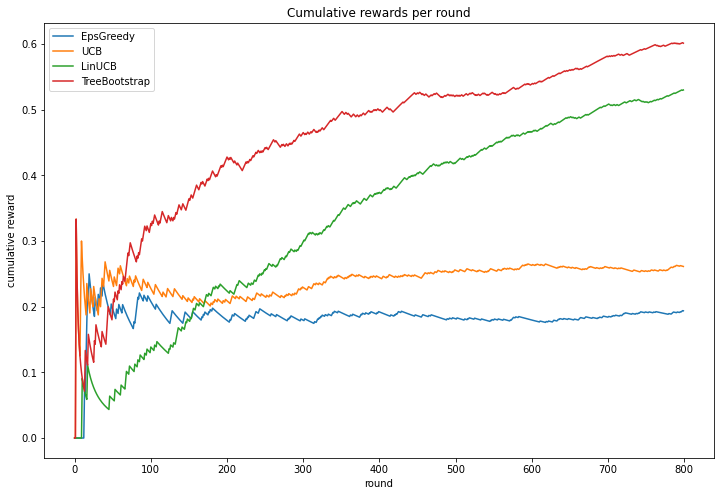

In [15]:
# your code here

#Evaluate each bandit
mab_EpsGreedy = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab_EpsGreedy, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

mab_UCB = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab_UCB, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

mab_LinUCB = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab_LinUCB, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

#uncomment after fixing RecursionError
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

#Plotting the results for each bandit
plt.figure(figsize=(12,8))

x_axis = np.linspace(1,len(results_EpsGreedy),len(results_EpsGreedy))
plt.plot(np.cumsum(results_EpsGreedy)/x_axis,label = 'EpsGreedy')

x_axis = np.linspace(1,len(results_UCB),len(results_UCB))
plt.plot(np.cumsum(results_UCB)/x_axis,label = 'UCB')

x_axis = np.linspace(1,len(results_LinUCB),len(results_LinUCB))
plt.plot(np.cumsum(results_LinUCB)/x_axis,label = 'LinUCB')

x_axis =np.linspace(1,len(results_TreeBootstrap),len(results_TreeBootstrap))
plt.plot(np.cumsum(results_TreeBootstrap)/x_axis,label = 'TreeBootstrap')

plt.title('Cumulative rewards per round')
plt.legend()
plt.xlabel('round')
plt.ylabel('cumulative reward')
plt.show()

From running the cell above multiple times, it is observed the plots vary from time to time. Hence, we run 100 simulations to obtain a more robust cumsum result and account for any random variation 

In [16]:
#initialise all classes of MAB
mab_EpsGreedy = EpsGreedy(10, 0.05)
mab_UCB = UCB(10, 1.0)
mab_LinUCB = LinUCB(10, 10, 1.0)
mab = TreeBootstrap(10, 10)

finaleps = np.zeros(800)
finalucb = finaleps.copy()
finaltree = finalucb.copy()

#running for 100 simulations 
#(ignore linucb for the sake of speeding up computational time because the terminal output is dependent on alpha values only)
n_sims = 100
results_LinUCB = offlineEvaluate(mab_LinUCB, arms, rewards, contexts, 800)
for i in range(n_sims):
    results_EpsGreedy = offlineEvaluate(mab_EpsGreedy, arms, rewards, contexts, 800)
    results_UCB = offlineEvaluate(mab_UCB, arms, rewards, contexts, 800)
    results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
    finaleps += results_EpsGreedy
    finalucb += results_UCB
    finaltree += results_TreeBootstrap

#find average rewards over 100 simulations at each time step
avg_finaleps = finaleps/n_sims
avg_finalucb = finalucb/n_sims
avg_finaltree = finaltree/n_sims

#each simulation has 800 rounds, so we print average rewards over 800 rounds here
print('EpsGreedy average reward', np.mean(avg_finaleps))
print('UCB average reward', np.mean(avg_finalucb))
print('LinUCB average reward', np.mean(results_LinUCB))
print('TreeBootstrap average reward', np.mean(avg_finaltree))


#Plotting the results for each bandit
plt.figure(figsize=(12,8))

x_axis = np.linspace(1,len(avg_finaleps),len(avg_finaleps))
plt.plot(np.cumsum(avg_finaleps)/x_axis,label = 'EpsGreedy')

x_axis = np.linspace(1,len(avg_finalucb),len(avg_finalucb))
plt.plot(np.cumsum(avg_finalucb)/x_axis,label = 'UCB')

x_axis = np.linspace(1,len(results_LinUCB),len(results_LinUCB))
plt.plot(np.cumsum(results_LinUCB)/x_axis,label = 'LinUCB')

x_axis =np.linspace(1,len(avg_finaltree),len(avg_finaltree))
plt.plot(np.cumsum(avg_finaltree)/x_axis,label = 'TreeBootstrap')

plt.title('Cumulative rewards per round after {} simulations'.format(n_sims))
plt.legend()
plt.xlabel('round')
plt.ylabel('cumulative reward')
plt.show()

KeyboardInterrupt: 

### 5.B. Parameter Optimisation using Grid Search

To find the optimal $\alpha$ for LinUCB, an iterative testing approach is applied to values in the range $0< \alpha < 5$

The approach is documented in the following steps:

**1.** Find the average reward for each $\alpha$-value using the OfflineEvaluation policy above

**2.** Choose the alpha $\alpha$ which maximises the average reward as the optimal value

In [ ]:
increment = 501 #specifies the step size

alpha_arr = np.linspace(0,5,increment) # take [0.01,0.02,0.03.......,5], intervals are chosen arbitrarily from trial and error since it yields a reasonable result to time ratio
#alpha_arr = np.linspace(0,1,11)
#note that alpha must be a positive real number, so we remove zero from our array
alpha_arr = np.delete(alpha_arr,0)

#initialise an array to store the average rewards for each alpha
final_r = np.zeros(len(alpha_arr))

#calculate the average reward for each alpha
for alpha in range(len(alpha_arr)):
    mab_LinUCB = LinUCB(10, 10, alpha_arr[alpha])
    results_LinUCB = offlineEvaluate(mab_LinUCB, arms, rewards, contexts, 800)
    final_r[alpha] = np.mean(results_LinUCB)

max_val = np.argmax(final_r) 

#plotting the graph
plt.figure(figsize=(12,8))
plt.plot(alpha_arr,final_r,label = "$alpha for LinUCB")
plt.title("Graph of average rewards vs. $alpha values")
plt.legend()
plt.xlabel('$alpha')
plt.ylabel('average reward')
plt.show()

print("optimal $\alpha$ value is {}, which gives the highest average reward of {}".format(alpha_arr[max_val],final_r[max_val]))

## 6. Implement KernelUCB contextual MAB

In [ ]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        if not np.issubdtype(type(n_dims), np.integer):
            raise TypeError("`n_dims` must be an integer")
        if not n_dims >= 0:
            raise ValueError("`n_dims` must be non-negative")
            
        if not gamma >= 0:
            raise ValueError("`gamma` must be non-zero and non-negative")
        if not eta >= 0:
            raise ValueError("`eta` must be non-negative")
            
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern        

        
        #intialise first round flag, default at 1 (switched off during update)
        self.first_round = 1
        
        #track the contexts of the sequence of chosen arms up to t
        self.context_log = []
        
        #track the rewards corresponding to each arm in the sequence of arms pulled up to t
        self.y = []
        
        #initialise with a dummy variable representing kernel matrix of dataset {x_1,.....x_t} 
        self.K_inv = 0
    
        
        
        
    def play(self, context):
        super().play(context)
        # your code here
        
        #track mean reward for each arm
        u = np.zeros(self.n_arms, dtype=float)
        
        #track the width of the confidence interval around mean rewards for each arm
        sigma = np.zeros(self.n_arms, dtype=float)
        
        #reshape the context for kernelisation
        cntxt = context.reshape(self.n_arms, self.n_dims)
        
        if self.first_round:
            u[0] = 1
        
        else:
            #reshape context log so that it has same columns as context vectors
            cntxt_log = np.array(self.context_log).reshape(-1, self.n_dims)
            #initialise k for all arms (#Note to self: for rbf kernel, the column size must match)
            k = self.kern(cntxt,cntxt_log) 
            
            for a in range(self.n_arms):
                #just like in the case of LinUCB, accessing matrix based on index gives an array form (n_dims,)
                #so we need to transform to 1D row vector to pass into rbf kernel
                cntxt_vec = np.array([cntxt[a]]) #shape is now (1,n_dims)
                sigma[a] = np.sqrt(self.kern(cntxt_vec,cntxt_vec)- k[a].reshape(-1,1).T @ self.K_inv @ k[a].reshape(-1,1))
                u[a] = k[a].T @ self.K_inv @ np.array(self.y).reshape(-1,1) + self.eta/np.sqrt(self.gamma)*sigma[a] 
                
        chosen_arm = np.random.choice(np.where(u == max(u))[0])
        return chosen_arm
            
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        #reshape the context
        cntxt = context.reshape(self.n_arms,self.n_dims)
        #update the context log
        for i in cntxt[arm]:
            self.context_log.append(i)
        #reshape the context log so that it has the same number of columns as context vector
        cntxt_log = np.array(self.context_log).reshape(-1, self.n_dims)
        #update reward history
        self.y.append(reward)
        
        k = self.kern(cntxt,cntxt_log)
    
        #make the context for an arm into a 1D vector for kernelisation
        cntxt_vec = np.array([cntxt[arm]])

        #initialise kernel matrix inverse if first round
        if self.first_round:
            self.K_inv = np.linalg.inv(self.kern(cntxt_vec,cntxt_vec) + self.gamma)
            self.first_round = 0 #turn the flag off after successfully updating
        else:
            b =  k[arm][:-1].reshape(-1,1)
            K_22 = np.linalg.inv(self.kern(cntxt_vec,cntxt_vec) + self.gamma - b.T @ self.K_inv @ b)
            K_11 = self.K_inv + K_22 * self.K_inv @ b @ b.T @ self.K_inv
            K_12 = -K_22 * self.K_inv @ b
            K_21 = -K_22 @ b.T @ self.K_inv
            top = np.hstack((K_11,K_12))
            btm = np.hstack((K_21,K_22))
            self.K_inv = np.vstack((top,btm))            
        
        
        
        
        

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

Given there are 2 tunable hyperparameters in Kernel UCB, we apply an iterative testing approach to $0< \gamma < 10$ for the x-axis and $0< \eta < 1$ for y-axis

In [ ]:
# your plotting code here
eta_values = np.linspace(0,1,11)
gamma_values = np.linspace(0,10,11)
gamma_values = gamma_values[1:] #gamma cannot be zero
results = np.zeros((len(eta_values),len(gamma_values)))

for i in range(len(eta_values)):
    for j in range(len(gamma_values)):
        mab = KernelUCB(10, 10, gamma_values[j], eta_values[i], rbf_kernel)
        results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        results[i][j] = np.mean(results_KernelUCB)

#get the coordinates of maximum value in the matrix and find what gamma and eta values they correspond to
out_pair = best_gamma_eta_combo(results,gamma_values,eta_values)
print('the optimal gamma-eta combination(s) (gamma,eta) are {}'.format(out_pair))
print('the highest average reward is {}'.format(np.max(results)))

#Plotting
plt.figure(figsize=(12,8))
plt.imshow(results, interpolation='nearest',cmap=plt.cm.viridis)
plt.title('Average Rewards for varying gamma and eta values')
plt.xlabel('gamma')
plt.ylabel('eta')
plt.colorbar()
plt.xticks(np.arange(len(gamma_values)), gamma_values, rotation=45)
plt.yticks(np.arange(len(eta_values)), eta_values)
plt.show()